Set up

In [1]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [2]:
# To generate GIFs
!pip install imageio
!pip install git+https://github.com/tensorflow/docs

  Cloning https://github.com/tensorflow/docs to /tmp/pip-req-build-9v0uhl9_
  Running command git clone -q https://github.com/tensorflow/docs /tmp/pip-req-build-9v0uhl9_
  Created wheel for tensorflow-docs: filename=tensorflow_docs-0.0.0705f63013e7f26ba6052e90ea3836153a47406c6_-cp36-none-any.whl size=143518 sha256=2ecfc5708b1a0d9fe548a695cb6437fe43208658a70335f2f1ca6e1c8d63b32d
  Stored in directory: /tmp/pip-ephem-wheel-cache-tc02e2u1/wheels/eb/1b/35/fce87697be00d2fc63e0b4b395b0d9c7e391a10e98d9a0d97f
Successfully built tensorflow-docs


In [3]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

Load and prepare the dataset

In [4]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [5]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

In [6]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [7]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

The Generator

In [8]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

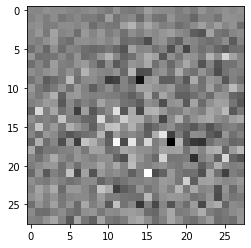

In [9]:
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

The Discriminator

In [10]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [11]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[0.00049444]], shape=(1, 1), dtype=float32)


Loss Optimizer

In [12]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [13]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [14]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [15]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [16]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [23]:
EPOCHS = 1
noise_dim = 100
num_examples_to_generate = 16

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [25]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Produce images for the GIF as we go
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [26]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

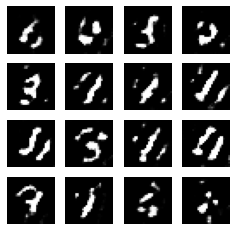

In [27]:
train(train_dataset, EPOCHS)

In [28]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [29]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)


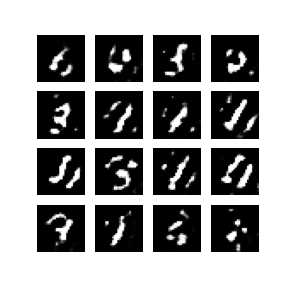

In [30]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

Understanding the Feature Maps of the Descriminator Model

In [70]:
# summarize feature map shapes
discriminator = make_discriminator_model()

model=discriminator
for i in range(len(model.layers)):
	layer = model.layers[i]

	print(i, layer.name, layer.output.shape)

0 conv2d_8 (None, 14, 14, 64)
1 leaky_re_lu_11 (None, 14, 14, 64)
2 dropout_8 (None, 14, 14, 64)
3 conv2d_9 (None, 7, 7, 128)
4 leaky_re_lu_12 (None, 7, 7, 128)
5 dropout_9 (None, 7, 7, 128)
6 flatten_4 (None, 6272)
7 dense_5 (None, 1)


In [64]:
image=[]
for i in train_dataset:
  image=i;
  break;


In [65]:
image[0].shape

TensorShape([28, 28, 1])

In [66]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)             

In [57]:
feature_maps = model.predict(image)

In [58]:
feature_maps.shape

(256, 14, 14, 64)

In [81]:
from matplotlib import pyplot

def plot_feature_maps(feature_maps):
  square = 8
  ix = 1
  for _ in range(square):
    for _ in range(square):
      # specify subplot and turn of axis
      ax = pyplot.subplot(square, square, ix)
      ax.set_xticks([])
      ax.set_yticks([])
      # plot filter channel in grayscale
      pyplot.imshow(feature_maps[0, :, :, ix-1], cmap='gray')
      ix += 1
  # show the figure
  pyplot.show()

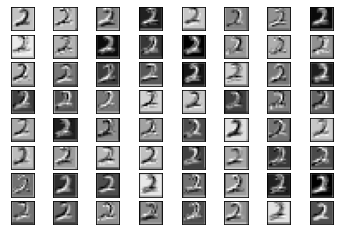

In [82]:
from keras.models import Model

# conv2d_4 (Conv2D)  Layer  
model_layers = Model(inputs=model.inputs, outputs=model.layers[0].output)
feature_maps = model_layers.predict(image)
plot_feature_maps(feature_maps)

In the Layer 1 conv2d_4 (Conv2D), our model is able to detect the shape of number 2. In almost all the pixels we can visualize the shape of 2 with diffrent sharpness and intensity.

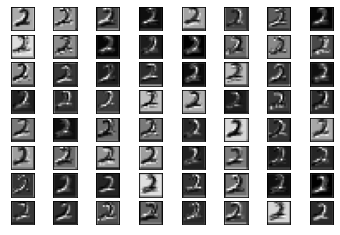

In [84]:
#leaky_re_lu_7 (LeakyReLU) Layer
model_layers = Model(inputs=model.inputs, outputs=model.layers[1].output)
feature_maps = model_layers.predict(image)
plot_feature_maps(feature_maps)

As aspected , Relu Layer has preserved most of the features from first layer. The figures are appearing more sharper now. The background has been darker and images are looking in more contrast now.

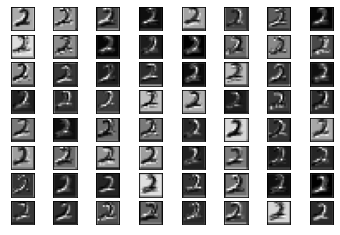

In [85]:
# dropout_4 (Dropout) Layer
model_layers = Model(inputs=model.inputs, outputs=model.layers[2].output)
feature_maps = model_layers.predict(image)
plot_feature_maps(feature_maps)

The primary purpose of dropout is to minimize the effect of overfitting within a trained network. However there seems to be almost no diffrence between present layer and previous layer.

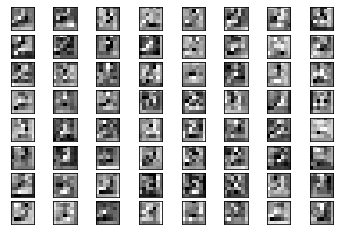

In [86]:

# conv2d_5 (Conv2D) Layer
model_layers = Model(inputs=model.inputs, outputs=model.layers[3].output)
feature_maps = model_layers.predict(image)
plot_feature_maps(feature_maps)

The  second CNN Layer, seems to detect the background features of the image. There seem to be no indication of any features related to the shape of the number. 

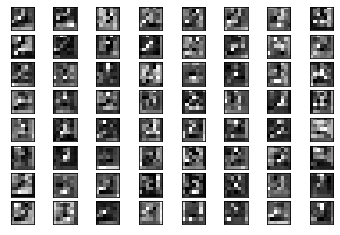

In [87]:

# leaky_re_lu_8 (LeakyReLU) Layer 

model_layers = Model(inputs=model.inputs, outputs=model.layers[4].output)
feature_maps = model_layers.predict(image)
plot_feature_maps(feature_maps)

Similar to the previous observation of Relu layer, the features of the above CNN layers are preserved and image is more shaper with the dark back ground contract.
